### Chess Hi-C analysis
This notebook documents the detection of structural changes during _Legionella_ infection of _Acanthamoeba castellanii_. We use [CHESS](https://github.com/vaquerizaslab/chess) to detect these changes

In [1]:
import os
import re
from os.path import expanduser, join
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import cooler
import pyranges as pr

In [2]:
warnings.filterwarnings('ignore')
home_dir = expanduser("~")
os.chdir(join(home_dir, 'Repos/Acastellanii_legionella_infection/'))
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
RES = 2000
CTL = f'data/output/cool/sub_uninfected.mcool::/resolutions/{RES}'
INF = f'data/output/cool/sub_infected.mcool::/resolutions/{RES}'
clr_ctl = cooler.Cooler(CTL)
clr_inf = cooler.Cooler(INF)
WIN = 100000
STEP = 8000
CHESS_DIR = 'data/output/chess'

First, I split the genome into overlapping sliding windows. Windows have a size of 100kb (50 bins) and the step size is 8kb (4 bins). I run chess on the control and infected maps to compute a similarity z-score (z-ssim) between conditions for each window.

In [13]:
%%bash -s "$WIN" "$STEP" "$CTL" "$INF" "$CHESS_DIR"
# Setup dirs
mkdir -p "$5"
mkdir -p "$5/features"
# Generate chromsizes file
# fasta must be indexed !
# samtools faidx data/input/genome/C3.fa
cut -f1,2 data/input/genome/C3.fa.fai > "$5/chrom.size"
chess pairs "$5/chrom.size" "$1" "$2" "$5/$1_win_$2_step.bed"
chess sim "$3" "$4" "$5/$1_win_$2_step.bed" "$5/$1_win_$2_step_legio_results.tsv" -p6

b"ERROR 1064 (42000) at line 1: You have an error in your SQL syntax; check the manual that corresponds to your MariaDB server version for the right syntax to use near '/output/chess/chrom.size.chromInfo' at line 1\n"
Commands were:

mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e "select chrom, size from data/output/chess/chrom.size.chromInfo"
b'INFO: trying CURL  for database data/output/chess/chrom.size\nurl: http://hgdownload.soe.ucsc.edu/goldenPath/data/output/chess/chrom.size/bigZips/data/output/chess/chrom.size.chrom.sizes\n'
Commands were:

fetchChromSizes data/output/chess/chrom.size


mkdir: cannot create directory ‘data/output/chess’: File exists
mkdir: cannot create directory ‘data/output/chess/features’: File exists
2021-07-08 11:23:04,725 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess pairs data/output/chess/chrom.size 100000 8000 data/output/chess/100000_win_8000_step.bed'
2021-07-08 11:23:05,285 INFO CHESS version: 0.3.6
2021-07-08 11:23:05,286 INFO FAN-C version: 0.9.14
2021-07-08 11:23:06,655 INFO No entry found with pybedtools. Trying to read from file.
2021-07-08 11:23:06,694 INFO Finished '/home/cmatthey/anaconda3/envs/py37/bin/chess pairs data/output/chess/chrom.size 100000 8000 data/output/chess/100000_win_8000_step.bed'
2021-07-08 11:23:07,470 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess sim data/output/cool/sub_uninfected.mcool::/resolutions/2000 data/output/cool/sub_infected.mcool::/resolutions/2000 data/output/chess/100000_win_8000_step.bed data/output/chess/100000_win_8000_step_legio_results.tsv -p6'
2021-07-08 11:23:08,03

Now we need to filter windows of interest based on two features:
* SN: Signal to noise ratio
* z-ssim: Z-score of similarity

Interesting windows will have a good signal-to-noise ratio and a low similarity score (changes happening between conditions).

In [3]:
### Chess change detection
chess = pd.read_csv(f'{CHESS_DIR}/{WIN}_win_{STEP}_step_legio_results.tsv', sep='\t')
wins = pd.read_csv(f'{CHESS_DIR}/{WIN}_win_{STEP}_step.bed', sep='\t', header=None)
chess['start'] = wins.iloc[:, 1]
# Make start position absolute (not relative to chromosome)
chess['abs_start'] = chess['start'].diff().fillna(0)
chromstart = chess.abs_start < 0
chess.abs_start[chromstart] = 1
chess.abs_start = chess.abs_start.cumsum()
# Remember abs position of chromosome starts
chromstart = chess.abs_start[chromstart]

We compute the median signal to noise ratio (SNR) across all windows and will use that as a threshold for selection.

<IPython.core.display.Javascript object>


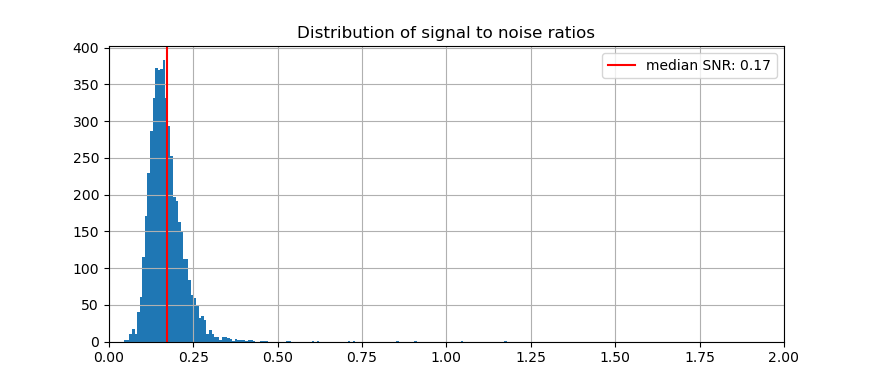

In [4]:
%matplotlib notebook
chess.SN.hist(bins=1000)
plt.xlim((0, 2))
med_snr = np.nanmean(chess.SN)
plt.axvline(med_snr, c='r', label=f'median SNR: {med_snr:.2f}')
plt.title("Distribution of signal to noise ratios")
plt.legend()

Now we can filter windows with a SNR above the median and a low similarity score.

<IPython.core.display.Javascript object>


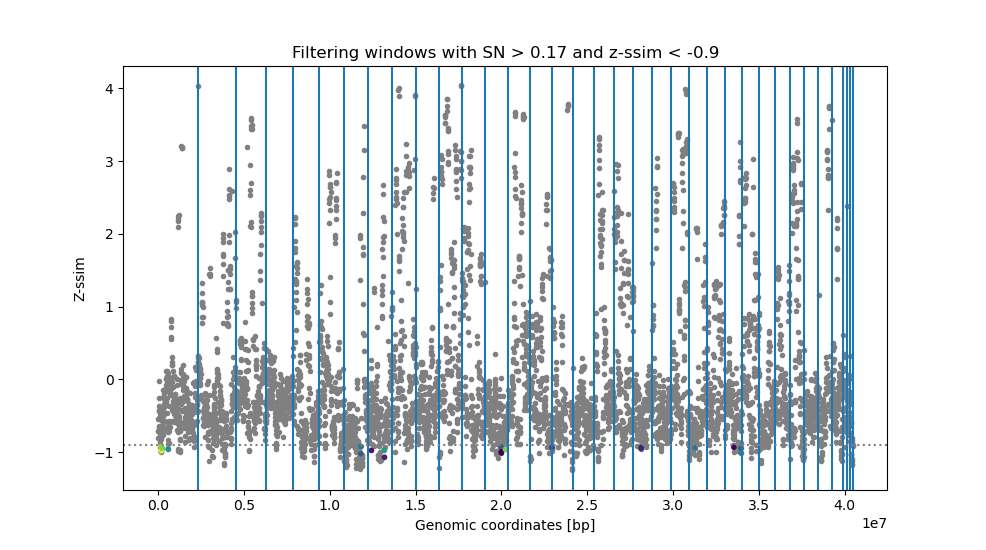

In [5]:
%matplotlib notebook
SN_THRESH = med_snr
ZSSIM_THRESH = -.9
hits = (chess.SN > SN_THRESH) & (chess.z_ssim < ZSSIM_THRESH)
plt.scatter(chess.abs_start, chess.z_ssim, c='gray', marker='.')
plt.scatter(chess.abs_start[hits], chess.z_ssim[hits], c=chess.SN[hits], marker='.')
for v in chromstart.values:
    plt.axvline(v)
plt.xlabel("Genomic coordinates [bp]")
plt.ylabel("Z-ssim")
plt.title(f"Filtering windows with SN > {SN_THRESH:.2f} and z-ssim < {ZSSIM_THRESH}")
wins.loc[hits, :].to_csv(f'{CHESS_DIR}/{WIN}_win_{STEP}_step_filtered.bed', header=None, index=False, sep='\t')
plt.axhline(ZSSIM_THRESH, c='grey',ls=':')

I then use `chess extract` to extract differential features in those filtered windows, and `chess crosscorrelate` to cluster these features by similarity.

In [260]:
%%bash -s "$WIN" "$STEP" "$CTL" "$INF" "$CHESS_DIR"
chess extract "$5/$1_win_$2_step_filtered.bed" "$3" "$4" "$5/features"
chess crosscorrelate "$5/features/lost_features.tsv" \
                     "$5/$1_win_$2_step_filtered.bed" \
                     "$5/features"

2021-07-08 20:08:01,126 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess extract data/output/chess/100000_win_8000_step_filtered.bed data/output/cool/sub_uninfected.mcool::/resolutions/2000 data/output/cool/sub_infected.mcool::/resolutions/2000 data/output/chess/features'
2021-07-08 20:08:01,706 INFO CHESS version: 0.3.6
2021-07-08 20:08:01,706 INFO FAN-C version: 0.9.14
2021-07-08 20:08:01,707 INFO Loading reference contact data
2021-07-08 20:08:24,310 INFO Loading region pairs
2021-07-08 20:08:24,310 INFO Applying image filtering to identify specific structures
2021-07-08 20:08:24,517 INFO Results collected
2021-07-08 20:08:24,577 INFO Finished '/home/cmatthey/anaconda3/envs/py37/bin/chess extract data/output/chess/100000_win_8000_step_filtered.bed data/output/cool/sub_uninfected.mcool::/resolutions/2000 data/output/cool/sub_infected.mcool::/resolutions/2000 data/output/chess/features'
2021-07-08 20:08:25,390 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess crossc

Now let's visualize the automatically extracted features.

In [6]:
import scipy.ndimage as ndi

# I made a PR to include these rotation functions in CHESS,
# if it is accepted, this code can be replaced by their API.

def rotate_feature(x, y, window_size, zoom_factor=1.0/0.7):
    """Rotate a single x,y coordinate within a region by -45 degrees.
    This allows conversion of coordinates from chess extract output to genomic bins.

    Parameters
    ----------
    x : int
        The x coordinate of a single point within the window, as found in the
        output of chess extract
    y : int
        The y coordinate of a single point within the window, as found in the
        output of chess extract.
    window_size : int
        The size of the window region.

    Returns
    -------
    x_r, y_r : tuple of int
        The rotated coordinates.
    """
    # NOTE: There will be some rounding errors when rotating the system. Not sure
    # what is the best way to handle them, for now I just round to the closest int.
    
    # Convert degree to radians
    theta = np.radians(-45)
    # Compute rotation matrix
    rot = np.array(
        [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    )
    # Get rotation center
    center = window_size / 2
    # Substract rotation center and rotate
    x_r, y_r = zoom_factor * rot @ np.array([x - center, y - center])
    # Add back rotation center
    x_r += center
    y_r += center
    return round(x_r), round(y_r)


def get_feature_coords(coords, win_size, win_bp_start, res):
    """Get basepair coordinates of a feature by rotating it and converting
    bins to coordinates

    Parameters
    ----------
    coords : tuple of int
        The coordinate of the feature within the window, as found in the
        output of chess extract: (xmin, xmax, ymin, ymax)
    win_size : int
        The size of the window region in bins.
    win_bp_start : int
        The start coordinate of the window in base pairs.
    res : int
        The resolution of the Hi-C matrix, i.e. the number of basepairs
        per bin.

    Returns
    -------
    x_coords, y_coords : tuple of lists of int
        The genomic coordinates of the feature on both axes, in
        the format: ([x_start, x_end], [y_start, y_end])
    """
    # Rotate input coordinates by 45 degrees to get genomic bins
    xmin, xmax, ymin, ymax = coords
    xmin_r, ymin_r = rotate_feature(ymin, ymin, win_size)
    xmin_r, ymax_r = rotate_feature(xmin, ymax, win_size)
    xmax_r, ymin_r = rotate_feature(xmin, ymin, win_size)


    # Generate new genomic coordinates
    x_coords = [xmin_r * res + win_bp_start, xmax_r * res + win_bp_start]
    y_coords = [ymin_r * res + win_bp_start, ymax_r * res + win_bp_start]

    return x_coords, y_coords


def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndi.zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = ndi.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

In [7]:
%matplotlib notebook
from chromosight.utils.preprocessing import detrend
from matplotlib.patches import Rectangle
import serpentine as serp
import scipy.ndimage as ndi

# Load features
def load_chess_features(wins_path: str, feature_dir: str):
    """Loads chess features (gained and lost) into a clean dataframe"""
    
    chess_wins = pd.read_csv(wins_path,
        sep='\t',
        usecols=[0, 1, 2, 6],
        names=['chrom', 'start', 'end', 'win_id']
    )
    # Read lost and gained features and attach window information
    chess_gained = pd.read_csv(
        join(feature_dir, 'gained_features.tsv'),
        usecols=range(6),
        names=['win_id', 'ft_id', 'xmin', 'xmax', 'ymin', 'ymax']
    ).merge(chess_wins, on='win_id', how='inner')
    chess_lost = pd.read_csv(
        join(feature_dir, 'lost_features.tsv'),
        usecols=range(6),
        names=['win_id', 'ft_id', 'xmin', 'xmax', 'ymin', 'ymax']
    ).merge(chess_wins, on='win_id', how='inner')
    
    # Combine gained and lost features in a single table
    chess_gained['state'] = 'gained'
    chess_lost['state'] = 'lost'
    chess_features = (
        pd.concat([chess_gained, chess_lost])
        .drop_duplicates(['xmin', 'xmax'])
        .reset_index(drop=True)
    )
    
    return chess_features


chess_features = load_chess_features(f'{CHESS_DIR}/{WIN}_win_{STEP}_step_filtered.bed', f'{CHESS_DIR}/features/')
chess_features

,win_id,ft_id,xmin,xmax,ymin,ymax,chrom,start,end,state
0,21,0,30,34,23,28,scaffold_1,168001,268001,gained
1,22,1,26,30,22,29,scaffold_1,176001,276001,gained
2,29,2,40,50,24,27,scaffold_1,232001,332001,gained
3,74,3,41,45,23,28,scaffold_1,592001,692001,gained
4,1561,4,30,32,19,21,scaffold_8,192001,292001,gained
5,1561,5,33,35,22,29,scaffold_8,192001,292001,gained
6,1561,6,0,14,23,28,scaffold_8,192001,292001,gained
7,2510,8,0,4,22,29,scaffold_13,920001,1020001,gained
8,2510,9,22,26,24,27,scaffold_13,920001,1020001,gained
9,2511,10,46,50,22,29,scaffold_13,928001,1028001,gained


In [8]:
uniq_wins = (
    chess_features[['chrom', 'start', 'end']]
    .sort_values(['chrom', 'start', 'end'])
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'})
)
disc_wins = pr.PyRanges(uniq_wins).merge().df
disc_wins['ucsc'] = disc_wins.apply(lambda r: f'{r.Chromosome}:{r.Start}-{r.End}', axis=1)
uniq_wins

,Chromosome,Start,End
0,scaffold_1,168001,268001
1,scaffold_1,176001,276001
2,scaffold_1,200001,300001
3,scaffold_1,232001,332001
4,scaffold_1,592001,692001
5,scaffold_13,920001,1020001
6,scaffold_13,928001,1028001
7,scaffold_13,936001,1036001
8,scaffold_13,1176001,1276001
9,scaffold_15,1272001,1372001


In [9]:
disc_wins

,Chromosome,Start,End,ucsc
0,scaffold_1,168001,332001,scaffold_1:168001-332001
1,scaffold_1,592001,692001,scaffold_1:592001-692001
2,scaffold_8,192001,292001,scaffold_8:192001-292001
3,scaffold_8,952001,1052001,scaffold_8:952001-1052001
4,scaffold_13,920001,1036001,scaffold_13:920001-1036001
5,scaffold_13,1176001,1276001,scaffold_13:1176001-1276001
6,scaffold_15,1272001,1372001,scaffold_15:1272001-1372001
7,scaffold_20,448001,556001,scaffold_20:448001-556001
8,scaffold_23,328001,428001,scaffold_23:328001-428001
9,scaffold_25,528001,628001,scaffold_25:528001-628001


In [10]:
from IPython.display import Markdown as md
md(
    f"These features originate from {uniq_wins.shape[0]} different windows "
    f"(actually {disc_wins.shape[0]} discontinuous intervals):"
)


These features originate from 18 different windows (actually 11 discontinuous intervals):

In [11]:
%matplotlib notebook
from ipywidgets import interact, interactive, fixed, interact_manual
import chromosight.utils.preprocessing as cup
import ipywidgets as widgets
from IPython.display import display
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5,5)
from matplotlib.patches import Polygon

def auto_rotate(xs, ys, winsize):
    """helper to rotate a list of xs and ys"""
    rot = list(map(
        lambda c: rotate_feature(c[0], c[1], winsize),
        zip(xs, ys)
    ))
    rot = [
        [r[0] for r in rot],
        [r[1] for r in rot]
    ]
    return rot[0], rot[1]


def show_chess_feature(window):
    # Extract features in window
    fts = chess_features.loc[chess_features.win_id == window, :]
    region = f"{fts.chrom.values[0]}:{fts.start.values[0]}-{fts.end.values[0]}"
    
    # Plot matrices
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4), dpi=80)
    for i, clr in enumerate([clr_inf, clr_ctl]):
        win_mat = clr.matrix(balance=True, sparse=True).fetch(region)
        ax[i].imshow(np.log(win_mat.toarray()), cmap='afmhot_r', rasterized=True)
    
    _, _, lratio = serp.serpentin_binning(
        clr_ctl.matrix(balance=False, sparse=False).fetch(region),
        clr_inf.matrix(balance=False, sparse=False).fetch(region),
        parallel=1,
        iterations=10,
        verbose=False,
    )
    ax[2].imshow(lratio - lratio.mean(), cmap='bwr', rasterized=True, vmin=-1, vmax=1)
    for i, title in enumerate(['Infected.', 'Control', 'Log2(Inf/Ctl)']):
        ax[i].set_title(title)
    plt.suptitle(f"Region: {region}")
    
    # Add markers at features positions
    winsize = win_mat.shape[0]
    winstart = fts.start.values[0]
    polys = []
    for i, ft in fts.iterrows():
        xmin, xmax, ymin, ymax = ft[2:6]
        coords_chess = [
            [xmin, xmin, xmax, xmax],
            [ymin, ymax, ymax, ymin],
        ]
        coords_rot = auto_rotate(*coords_chess, winsize)
        coords_rot = list(zip(*coords_rot))
        lost = ft['state'] == 'lost'
        col = 'red' if lost else 'green'
        for a in ax:
            ft_patch = Polygon(coords_rot, True, edgecolor=col, facecolor='none', linewidth=3)
            a.add_patch(ft_patch)
    #plt.savefig(f'{region}_win_{window}_salmonella_changes.svg')
    plt.show()

pl = interactive(show_chess_feature, window=np.unique(chess_features.win_id.tolist()))
display(pl)

#for i in np.unique(chess_features.win_id.tolist()):
#    show_chess_feature(i)

interactive(children=(Dropdown(description='window', options=(21, 22, 25, 29, 74, 1561, 1656, 2510, 2511, 2512…

When using recommended (pretty stringent) filters, CHESS identifies 3 regions undergoing structural changes during infection. Now let's have a look at genes located in these neighbourhoods

In [267]:
# Using liftover from Neff annotations (not used anymore)
liftover = pd.read_csv('data/tmp/liftoff/neff_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

In [12]:
# Load relevant columns from annotation file and select mRNA only
annot = (
    pd.read_csv(
        'data/input/annotations/c3_annotations/Acanthamoeba_castellanii_C3.gff3',
        sep='\t',
        comment='#',
        header=None,
        usecols=[0, 2, 3, 4, 8],
        names=['chrom', 'type', 'start', 'end', 'attr'])
    .query('type=="mRNA"')
)
annot['accession'] = annot['attr'].str.replace(r'ID=([^;]*)\.mRNA\.[0-9]+;.*', r'\1')
# For each gene, retain only the longest transcript (to remove redundancy)
annot['length']= annot['end'] - annot['start']
annot = (
    annot
    .sort_values('length', )
    .groupby('accession')
    .head(1)
    .sort_values(['chrom', 'start', 'end'])
    .reset_index(drop=True)
)
# Extract functinoal annotations as individual columns
annot['desc'] = annot['attr'].str.replace(r'.*product=([^;]*);.*', r'\1')
annot['IPR'] = annot['attr'].apply(lambda s: re.findall(r'InterPro:(IPR[0-9]+)', s))
annot['PFAM'] = annot['attr'].apply(lambda s: re.findall(r'PFAM:(PF[0-9]+)', s))
#annot[['IPR', 'PFAM']] = annot[['IPR', 'PFAM']].applymap(lambda l: l if len(l) else np.nan)

annot

,chrom,type,start,end,attr,accession,length,desc,IPR,PFAM
0,scaffold_1,mRNA,504,5457,ID=VMHBD_00001.mRNA.1;Parent=VMHBD_00001;produ...,VMHBD_00001,4953,hypothetical protein,"[IPR027417, IPR001806, IPR020849, IPR005225, I...","[PF00071, PF08477, PF00651]"
1,scaffold_1,mRNA,5352,9953,ID=VMHBD_00002.mRNA.1;Parent=VMHBD_00002;produ...,VMHBD_00002,4601,hypothetical protein,[],[]
2,scaffold_1,mRNA,9877,10656,ID=VMHBD_00003.mRNA.1;Parent=VMHBD_00003;produ...,VMHBD_00003,779,hypothetical protein,[IPR017920],[PF07258]
3,scaffold_1,mRNA,10702,11622,ID=VMHBD_00004.mRNA.1;Parent=VMHBD_00004;produ...,VMHBD_00004,920,hypothetical protein,[],[]
4,scaffold_1,mRNA,11710,30748,ID=VMHBD_00005.mRNA.2;Parent=VMHBD_00005;produ...,VMHBD_00005,19038,hypothetical protein,"[IPR001876, IPR003877, IPR000569, IPR013320, I...","[PF00622, PF00076, PF00632]"
...,...,...,...,...,...,...,...,...,...,...
16885,scaffold_97,mRNA,5588,6107,ID=VMHBD_16886.mRNA.1;Parent=VMHBD_16886;produ...,VMHBD_16886,519,hypothetical protein,[],[]
16886,scaffold_97,mRNA,7070,7516,ID=VMHBD_16887.mRNA.1;Parent=VMHBD_16887;produ...,VMHBD_16887,446,hypothetical protein,"[IPR001584, IPR012337]",[]
16887,scaffold_99,mRNA,701,2228,ID=VMHBD_16888.mRNA.1;Parent=VMHBD_16888;produ...,VMHBD_16888,1527,hypothetical protein,"[IPR003613, IPR013083]",[PF04564]
16888,scaffold_99,mRNA,3089,4240,ID=VMHBD_16889.mRNA.1;Parent=VMHBD_16889;produ...,VMHBD_16889,1151,hypothetical protein,[],[]


In [13]:
import requests
from tqdm import tqdm
from adjustText import adjust_text
tqdm.pandas()
pfam_cache = {}

def fetch_pfam_desc(acc: str) -> str:
    """Given a PFAM accession, fetch the corresponding
    human readable description"""
    try:
        return pfam_cache[acc]
    except KeyError:
        url = f'https://pfam.xfam.org/family?output=xml&acc={acc}'
        response = requests.get(url).text
        # For some reason, the description field cannot be parsed
        # correctly by the xml module, so we do it manually
        start = response.find('<description>') + 14
        end = response.find('</description>') - 1
        desc = re.sub('<!\[CDATA\[\n', '', response[start:end])
        desc = re.sub('\n\]\]>\n', '', desc)
        pfam_cache[acc] = desc
        return desc

#annot['PFAM_desc'] = annot.PFAM.progress_apply(lambda p: fetch_pfam_desc(p[0]) if len(p) else '')


def query_ucsc_df(query, df):
    r_chrom, bp = query.split(':')
    r_start, r_end = map(int, bp.split('-'))
    result = df.query(f'(chrom == "{r_chrom}") & (end >= {r_start}) & (start < {r_end})')
    return result
    
def map_annot_viz(viz_range, genes_df):
    local_genes = query_ucsc_df(viz_range, genes_df)
    r_start = int(viz_range.split(':')[1].split('-')[0])
    local_genes['bin'] = local_genes['start'] // 2000 - r_start//2000
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
    annot_col = [
        'grey' if a == 'hypothetical protein' else 'blue' for a in local_genes.desc
    ]
    ax[0].imshow(detrend(clr_ctl.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[1].imshow(detrend(clr_inf.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[0].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    ax[1].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    ax[2].scatter([30]*len(local_genes.bin), local_genes.bin, s=10, c=annot_col)
    texts = []
    for i, g in tqdm(local_genes.iterrows(), total=local_genes.shape[0]):
        if g.desc != 'hypothetical protein':
            desc = g.desc[:50]
            #ax[2].annotate(s=desc, xy=(0.1, g.bin), fontsize=7)
        elif len(g.PFAM):
            desc = fetch_pfam_desc(g.PFAM[0])[:50]
            # desc='testtesttafagagdgafggfsgasg' # debug
            #ax[2].annotate(s=desc, xy=(0.1, g.bin), fontsize=7) 
        else:
            continue
        texts.append(plt.text(30, g.bin, desc, size=7))
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color='grey', lw=0.5),
    )
            

The first region spans scaffold_7:982002-1110001 when concatenating all windows involved. In this region, there is a border shift around bin 20. This shift enlarges a domain containing two genes:
* An AMP binding enzyme domain containing protein
* A fascin subfamily protein. [According to NCBi](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd00257) these protein are involved in phosphorylation and bind actin. Could be interesting in the context of Legio infection ? (signaling + vesicle transport)

The second region spans scaffold_13:1308001-1408001 when concatenating all windows involved. The feature is not so clear here, but we can see a strengthening cross pattern around bin 38. The genes that seem to be involved in this cross (i.e. put into contact) are:
* An aminotransferase (class V)
* Hydroxymethyltransferase
* Homoserine acetyltransferase
* A Rho GAP (GTPase) domain containing protein
* A leucine rich repeat domain containing protein.

> Note: In the viscinity of the cross, there are also an Ankyrin repeat containing protein and a DIL domain containing protein([According to interpro](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002710/), this is an actin-based molecular motor for cargo transport).

The third region spans scaffold_26:590002-698001 when concatenating all windows involved. It's hard to see what change there is, CHESS seems to think it is the tiny looping interaction around bin 35. Which would involve only two genes:
* ribonuclease HI
* A NmrAlike family protein

In [15]:
%matplotlib notebook
viz = interactive(map_annot_viz, viz_range=disc_wins.ucsc.values.tolist(), genes_df=fixed(annot))
display(viz)

interactive(children=(Dropdown(description='viz_range', options=('scaffold_1:168001-332001', 'scaffold_1:59200…

In [ ]:
pfam_cache

### Differential expression

Now that we have identified a group of genes with 3D changes, let's check whether their expression also changes during infection.

In [157]:
#diff_expr = pd.read_csv('data/output/diff_expr/de_genes.tsv', sep='\t')
diff_expr = pd.read_csv('data/output/diff_expr/c3_diff_expr.tsv', sep='\t')
diff_expr = diff_expr.reset_index().rename(columns={'index': 'accession'})

In [ ]:
# Gather list of gene accessions in any of the regions reported by CHESS
chess_acc = pr.PyRanges(
    annot[['chrom', 'start', 'end', 'accession']]
    .rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'})
).join(
    pr.PyRanges(disc_wins)).df['accession']
chess_acc = np.unique(chess_acc)

Visualizing the expression of genes from the region (red) compared to the rest of the genome (grey). Genes which pass differential expression threshold are in clear, while others are blurred.

<IPython.core.display.Javascript object>


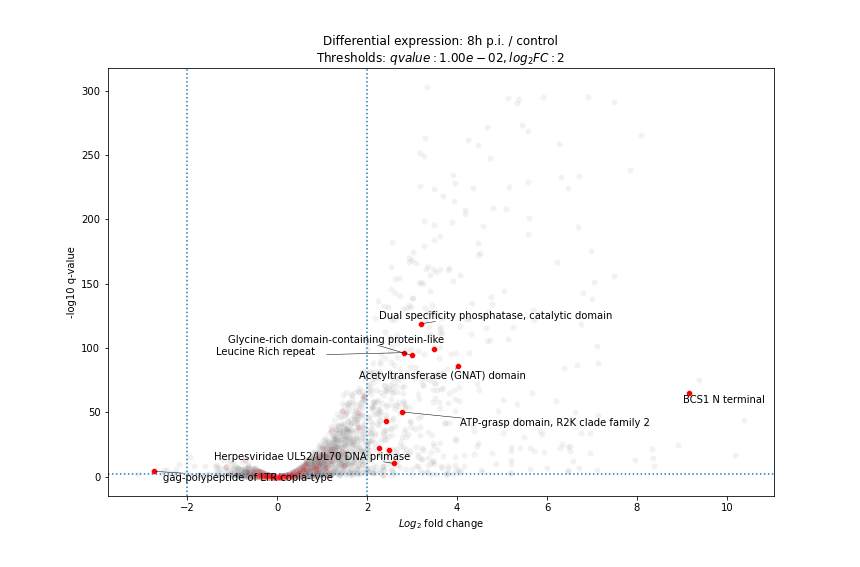

Text(0.5, 1.0, 'Differential expression: 8h p.i. / control\nThresholds: $qvalue: 1.00e-02, log_2FC: 2$')

In [371]:
%matplotlib notebook
import adjustText
FC = 2 # Threshold for log2 fold change
PLOG = 2 # Threshold for -log10(pvalue)
diff_expr['log_padj'] = -np.log10(diff_expr.padj)
chess_genes = diff_expr.loc[diff_expr.accession.isin(chess_acc), :]
candidates = chess_genes.loc[(diff_expr.log_padj > PLOG) & (diff_expr.log2FoldChange.abs() > FC), :]
sns.scatterplot(data=diff_expr, x='log2FoldChange', y='log_padj', color='grey', alpha=0.1)
sns.scatterplot(data=chess_genes, x='log2FoldChange', y='log_padj', color='red', alpha=0.1)

# Genes that pass the FC and P-values thresholds are not transparent
sns.scatterplot(data=candidates, x='log2FoldChange', y='log_padj', color='red')
# And they have labels
candidate_labels = []
for _, r in candidates.iterrows():
    pfam = annot.PFAM[annot.accession == r.accession].values[0]
    if len(pfam):
        lab = plt.text(
            r.log2FoldChange,
            r.log_padj,
            fetch_pfam_desc(pfam[0])
        )
        candidate_labels.append(lab)
adjustText.adjust_text(candidate_labels, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.axvline(FC, ls=':')
plt.axvline(-FC, ls=':')
plt.axhline(PLOG, ls=':')
plt.xlabel("$Log_2$ fold change")
plt.ylabel("-log10 q-value")
plt.title(f"Differential expression: 8h p.i. / control\nThresholds: $qvalue: {10**-PLOG:.2e}, log_2FC: {FC}$")

<IPython.core.display.Javascript object>


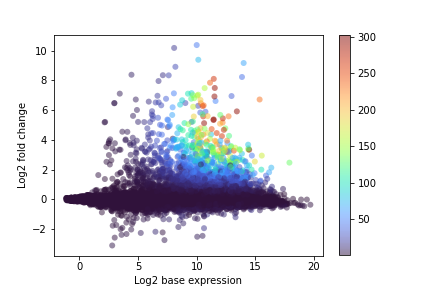

In [398]:
plt.figure()
plt.scatter(
    np.log2(diff_expr.baseMean),
    diff_expr.log2FoldChange,
    c=diff_expr.log_padj,
    edgecolors='none',
    alpha=0.5,
    cmap='turbo'
)
plt.xlabel("Log2 base expression")
plt.ylabel("Log2 fold change")
plt.colorbar()

Here is the list of differentially expressed genes which fall in regions from CHESS:

In [372]:
candidates

,accession,baseMean,log2FoldChange,lfcSE,pvalue,padj,logpval,log_padj
88,VMHBD_00089,2486.136299,3.479694,0.163420,7.724934e-102,7.710152e-100,99.112937,99.112937
97,VMHBD_00098,2151.490662,3.193425,0.136931,1.268148e-121,1.541706e-119,118.811998,118.811998
246,VMHBD_00247,220.214600,2.259381,0.225834,1.173536e-24,2.983475e-23,22.525278,22.525278
249,VMHBD_00250,16378.389110,9.167377,0.531757,8.088931e-68,4.973001e-66,65.303381,65.303381
259,VMHBD_00260,151.886972,-2.734982,0.718594,7.139210e-06,7.107998e-05,4.148253,4.148253
7019,VMHBD_07020,355.524095,2.480584,0.259864,1.096523e-22,2.622734e-21,20.581246,20.581246
7020,VMHBD_07021,395.062774,2.425140,0.173571,1.740479e-45,7.179031e-44,43.143934,43.143934
8270,VMHBD_08271,704.628441,2.816426,0.134109,4.247737e-99,4.112675e-97,96.385876,96.385876
8277,VMHBD_08278,11838.436621,7.761692,0.165086,0.000000e+00,0.000000e+00,inf,inf
8280,VMHBD_08281,43.052983,2.608345,0.393818,3.471408e-12,5.444151e-11,10.264070,10.264070


And corresponding PFAM annotations:

In [386]:
print(
    annot.loc[annot.accession.isin(candidates.accession), :]
    .drop(['attr', 'length', 'desc', 'type', 'IPR'], axis=1)
    .assign(PFAM=lambda df: df.PFAM.apply(lambda l: fetch_pfam_desc(l[0]) if len(l) else ''))
    .to_markdown()
)

|       | chrom       |   start |    end | accession   | PFAM                                           |
|------:|:------------|--------:|-------:|:------------|:-----------------------------------------------|
|    88 | scaffold_1  |  229531 | 231436 | VMHBD_00089 |                                                |
|    97 | scaffold_1  |  256109 | 256851 | VMHBD_00098 | Dual specificity phosphatase, catalytic domain |
|   246 | scaffold_1  |  642161 | 644971 | VMHBD_00247 |                                                |
|   249 | scaffold_1  |  647873 | 649480 | VMHBD_00250 | BCS1 N terminal                                |
|   259 | scaffold_1  |  675771 | 676860 | VMHBD_00260 | gag-polypeptide of LTR copia-type              |
|  7019 | scaffold_20 |  485762 | 486904 | VMHBD_07020 |                                                |
|  7020 | scaffold_20 |  487178 | 487429 | VMHBD_07021 |                                                |
|  8270 | scaffold_23 |  341890 | 344394 | VMH

### Appendix : CHESS analysis on individual replicates
The CHESS analysis was done on the merge of 2 replicates. Here I check whether the results hold for both replicates separately. Since the coverage will be lower, I may need to decrease the signal to noise threshold a bit to recover regions.

In [300]:
%%bash -s "$WIN" "$STEP" "$RES" "$CHESS_DIR"
# Setup dirs
mkdir -p "$4/rep1"
mkdir -p "$4/rep2"
mkdir -p "$4/features"

#COV=$(cooler info data/output/cool/AT419.cool | grep sum | sed 's/[^0-9]//g')
#COV=$((COV-1))
#function sub_cool(){
#    # x/y.mcool::/URI -> x/y.cool_sub 
#    local __LIB="${1/mcool::*/cool}_sub"
#    cooltools random-sample -c "$COV" "$1" "$__LIB"
#
#    echo "$__LIB"
#}

# Generate chromsizes file and  windows
cut -f1,2 data/input/genome/C3.fa.fai > chess/chrom.size
chess pairs "$4/chrom.size" "$1" "$2" "$4/$1_win_$2_step.bed"

chess sim "data/output/cool/AT419.mcool::/resolutions/$3" \
          "data/output/cool/AT420.mcool::/resolutions/$3" \
          "$4/$1_win_$2_step.bed" \
          "$4/rep1/$1_win_$2_step_legio_results.tsv" -p6
chess sim "data/output/cool/AT421.mcool::/resolutions/$3" \
          "data/output/cool/AT418.mcool::/resolutions/$3" \
          "$4/$1_win_$2_step.bed" \
          "$4/rep2/$1_win_$2_step_legio_results.tsv" -p6

b"ERROR 1064 (42000) at line 1: You have an error in your SQL syntax; check the manual that corresponds to your MariaDB server version for the right syntax to use near '/output/chess/chrom.size.chromInfo' at line 1\n"
Commands were:

mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e "select chrom, size from data/output/chess/chrom.size.chromInfo"
b'INFO: trying CURL  for database data/output/chess/chrom.size\nurl: http://hgdownload.soe.ucsc.edu/goldenPath/data/output/chess/chrom.size/bigZips/data/output/chess/chrom.size.chrom.sizes\n'
Commands were:

fetchChromSizes data/output/chess/chrom.size


2021-07-08 20:19:21,303 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess pairs data/output/chess/chrom.size 100000 8000 data/output/chess/100000_win_8000_step.bed'
2021-07-08 20:19:21,888 INFO CHESS version: 0.3.6
2021-07-08 20:19:21,888 INFO FAN-C version: 0.9.14
2021-07-08 20:19:23,903 INFO No entry found with pybedtools. Trying to read from file.
2021-07-08 20:19:23,916 INFO Finished '/home/cmatthey/anaconda3/envs/py37/bin/chess pairs data/output/chess/chrom.size 100000 8000 data/output/chess/100000_win_8000_step.bed'
2021-07-08 20:19:24,690 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess sim data/output/cool/AT419.mcool::/resolutions/2000 data/output/cool/AT420.mcool::/resolutions/2000 data/output/chess/100000_win_8000_step.bed data/output/chess/rep1/100000_win_8000_step_legio_results.tsv -p6'
2021-07-08 20:19:25,252 INFO CHESS version: 0.3.6
2021-07-08 20:19:25,252 INFO FAN-C version: 0.9.14
2021-07-08 20:19:25,253 INFO Loading reference contact data
Expected 

Globally, replicate experiments are fairly well correlated in terms of window similarity (between conditions). However, when it comes to signal / noise ratio, a subset of windows (i.e. regions) are decorrelated between experiments. This suggest that there is more noise in one experiment than the other and is most likely due to AT419 having less informative contacts than other samples.

<IPython.core.display.Javascript object>


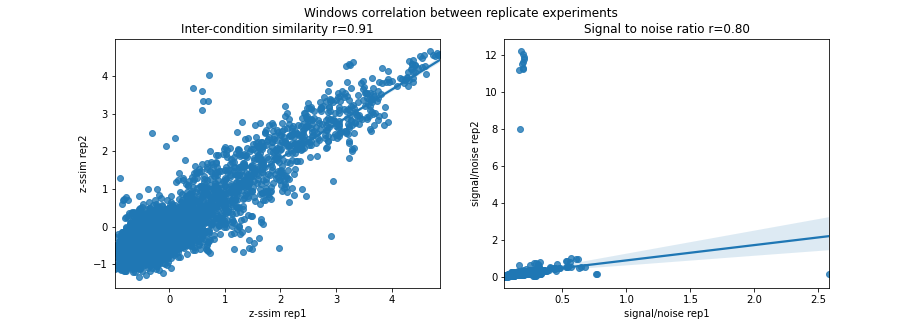

Text(0, 0.5, 'signal/noise rep2')

In [326]:
%matplotlib notebook
import scipy.stats as ss
def prepro_chess(df, wins):
    df['start'] = wins.iloc[:, 1]
    df['abs_start'] = df['start'].diff().fillna(0)
    chromstart = df.abs_start < 0
    df.abs_start[chromstart] = 1
    df.abs_start = df.abs_start.cumsum()
    
    return df

### Chess change detection
chess_r1 = pd.read_csv(f'{CHESS_DIR}/rep1/{WIN}_win_{STEP}_step_legio_results.tsv', sep='\t')
chess_r2 = pd.read_csv(f'{CHESS_DIR}/rep2/{WIN}_win_{STEP}_step_legio_results.tsv', sep='\t')
chess_r1 = prepro_chess(chess_r1, wins)
chess_r2 = prepro_chess(chess_r2, wins)

fig, ax = plt.subplots(1, 2)
cap_filter = chess_r2.SN < 3 # Remove some extremely high values
sns.regplot(x=chess_r1.z_ssim, y=chess_r2.z_ssim, ax=ax[0])
sns.regplot(x=chess_r1.SN, y=chess_r2.SN, ax=ax[1])

plt.suptitle('Windows correlation between replicate experiments')
na_filter = ~np.isnan(chess_r1.z_ssim) & ~np.isnan(chess_r2.z_ssim)# & cap_filter
ax[0].set_title(
    'Inter-condition similarity '
    f'r={ss.pearsonr(chess_r1.z_ssim[na_filter], chess_r2.z_ssim[na_filter])[0]:.2f}'
)
ax[1].set_title(
    'Signal to noise ratio '
        f'r={ss.spearmanr(chess_r1.SN[na_filter], chess_r2.SN[na_filter])[0]:.2f}'
)
ax[0].set_xlabel('z-ssim rep1'); ax[0].set_ylabel('z-ssim rep2')
ax[1].set_xlabel('signal/noise rep1'); ax[1].set_ylabel('signal/noise rep2')

If we plot window similarity along the genome for both replicates and highlight windows with a good signal/noise and low similarity for each replicate separately, we see the set of 'candidate' windows differ.
Note I had to lower the SN threshold to include noisier windows since the coverage is lower than in the merge.

<IPython.core.display.Javascript object>


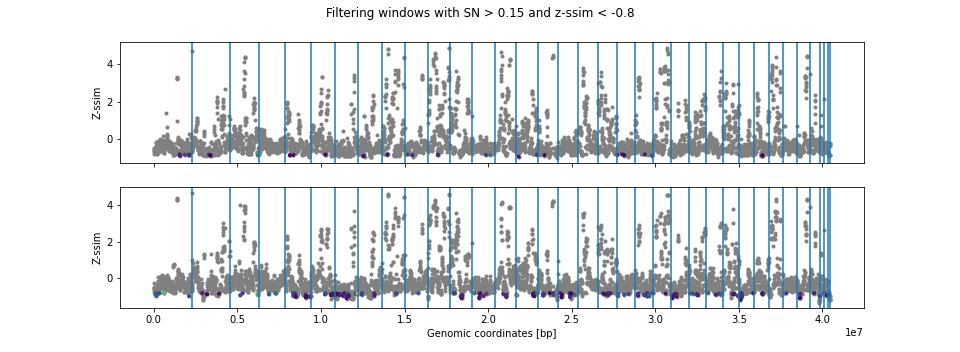

In [366]:
%matplotlib notebook
SN_THRESH = 0.15
ZSSIM_THRESH = -0.8

fig, ax = plt.subplots(2, 1, sharex=True)
for df, a in zip([chess_r1, chess_r2], ax):
    hits = (df.SN > SN_THRESH) & (df.z_ssim < ZSSIM_THRESH)
    a.scatter(df.abs_start, df.z_ssim, c='gray', marker='.')
    a.scatter(df.abs_start[hits], df.z_ssim[hits], c=df.SN[hits], marker='.')
    for v in chromstart.values:
        a.axvline(v)
    a.set_ylabel("Z-ssim")
ax[1].set_xlabel("Genomic coordinates [bp]")
plt.suptitle(f"Filtering windows with SN > {SN_THRESH} and z-ssim < {ZSSIM_THRESH}")
wins.loc[hits, :].to_csv(f'{CHESS_DIR}/{WIN}_win_{STEP}_step_filtered.bed', header=None, index=False, sep='\t')

Let's isolate the set of candidate windows common to both replicates and compare it to the merge:

In [368]:
na_filter = ~np.isnan(chess_r1.z_ssim) & ~np.isnan(chess_r2.z_ssim)
hits_r1 = na_filter & (chess_r1.SN > SN_THRESH) & (chess_r1.z_ssim < ZSSIM_THRESH)
hits_r2 = na_filter &(chess_r2.SN > SN_THRESH) & (chess_r2.z_ssim < ZSSIM_THRESH)
hits_merge = na_filter & (chess.SN > SN_THRESH) & (chess.z_ssim < ZSSIM_THRESH)
set_r1 = set(np.flatnonzero(hits_r1))
set_r2 = set(np.flatnonzero(hits_r2))
set_merge = set(np.flatnonzero(hits_merge))

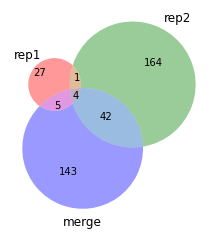

In [370]:
%matplotlib inline
plt.figure()
venn3([set_r1, set_r2, set_merge], set_labels=['rep1', 'rep2', 'merge'])

Results were not very conclusive with the intersect of replicate candidate windows. This is most likely due to the low coverage of AT419; when all replicates are subsampled to this coverage. CHESS cannot yield accurate results at the sample coverage we have here, and it is probably wiser to use the merged samples instead.